# **Plant Health Detection**

### Setup

In [1]:
# Connecting to web server
import anvil.server
import anvil.media
import anvil.mpl_util
anvil.server.connect("Put_Anvil_Uplink_Key_Here")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


### CNN

In [2]:
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from IPython.display import clear_output

Using TensorFlow backend.


In [3]:
# Loading model
R_DIR = os.getcwd()
model=load_model(os.path.join(R_DIR, 'Plant_Health_CNN\\plant_health_CNN_model.h5'))

# Loading labels
image_labels = pickle.load(open(os.path.join(R_DIR, 'Plant_Health_CNN\\plant_labels.pkl'), 'rb'))
clear_output()

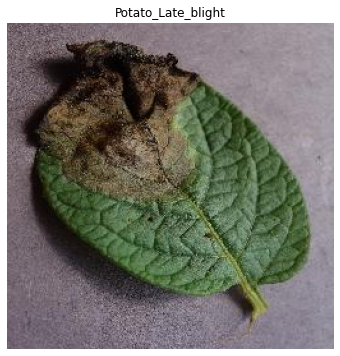

In [46]:
# Initialization of CNN model on server
def detect_health(pth):
  img = image.load_img(pth, target_size=(256, 256))
  x = image.img_to_array(img)
  x = x/255
  maximum=max(model.predict(np.expand_dims(x, axis=0)))
  mx=max(maximum)
  if mx > 0.80:
    result = np.argmax(model.predict([np.expand_dims(x, axis=0)]),axis=1)
    result_label= image_labels.classes_[result][0]
    load_image=image.load_img(pth)
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.title(result_label)
    plt.imshow(load_image)
  else:
    load_image=image.load_img(pth)
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.title('Detection Error: Unable to detect, Try again with valid image')
    plt.imshow(load_image)
pth="example.JPG"
detect_health(pth)

### Mask RCNN

In [5]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mrcnn import visualize
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from IPython.display import clear_output

In [6]:
# Setting up directory path
ROOT_DIR = os.getcwd()

MODEL_DIR = os.path.join(ROOT_DIR, "Plant_Health_MaskRCNN\\logs")

CUSTOM_DIR = os.path.join(ROOT_DIR, "Plant_Health_MaskRCNN\\Dataset")

In [7]:
class CustomConfig(Config):
    NAME = "object"

    # Processing no of images based on GPU configuration
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6
    
    USE_MINI_MASK = False
    
    MASK_SHAPE = [56, 56]

In [8]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        # Adding classes
        self.add_class("object", 1, "Potato_Early_Blight")
        self.add_class("object", 2, "Potato_Healthy")
        self.add_class("object", 3, "Potato_Late_Blight")
        self.add_class("object", 4, "Tomato_Healthy")
        self.add_class("object", 5, "Tomato_Leaf_Mold")
        self.add_class("object", 6, "Tomato_Leaf_Spot")

        # Setting up dataset path
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Loading JSON file
        annotations1 = json.load(open(os.path.join(dataset_dir, 'annotations.json')))
        annotations = list(annotations1.values())

        # Getting images with annotations
        annotations = [a for a in annotations if a['regions']]

        # Getting x and y coordinates of polygon (regions)
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Potato_Early_Blight": 1,"Potato_Healthy": 2,"Potato_Late_Blight": 3,
                         "Tomato_Healthy": 4,"Tomato_Leaf_Mold": 5,"Tomato_Leaf_Spot": 6}

            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    # Generating instance masks for an image
    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Getting indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [9]:
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
clear_output()

In [10]:
# Loading model
config = CustomConfig()
model_ = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

weights_path = os.path.join(MODEL_DIR,"object20230110T1509/mask_rcnn_object_0025.h5")
model_.load_weights(weights_path, by_name=True)
clear_output()

In [47]:
# Plotting Image
def get_ax(rows=1, cols=1, size=7):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  208.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   85.20000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


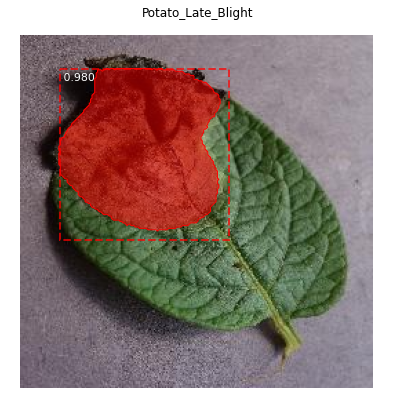

In [48]:
# Initialization of Mask RCNN model on server
def detect_hlth(pth):
    image1 = mpimg.imread(pth)
    results1 = model_.detect([image1], verbose=1)
    ax = get_ax(1)
    r1 = results1[0]
    lbl_list=["Potato_Early_Blight","Potato_Healthy","Potato_Late_Blight","Tomato_Healthy","Tomato_Leaf_Mold",
              "Tomato_Leaf_Spot","Detection Error: Unable to detect, Try again with valid image",""]
    empty_list=["","","","","","",""]
    try:
        cls_value=r1['class_ids'][0]
    except IndexError:
        cls_value=7

    if cls_value==1:
        c1=lbl_list[0]
        c2,c3,c4,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==2:
        c2=lbl_list[1]
        c1,c3,c4,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==3:
        c3=lbl_list[2]
        c1,c2,c4,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==4:
        c4=lbl_list[3]
        c1,c2,c3,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==5:
        c5=lbl_list[4]
        c1,c2,c3,c4,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==6:
        c6=lbl_list[5]
        c1,c2,c3,c4,c5,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    else:
        err=lbl_list[6]
        c1,c2,c3,c4,c5,c6=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    
    visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],empty_list,r1['scores'], 
                                ax=ax,title=c1 or c2 or c3 or c4 or c5 or c6  or err)
pth = "example.JPG"
detect_hlth(pth)

### UI

In [50]:
# CNN 
@anvil.server.callable
def detect_health(file):
  with anvil.media.TempFile(file) as filename:
    img = image.load_img(filename, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x/255
    maximum=max(model.predict(np.expand_dims(x, axis=0)))
    mx=max(maximum)
    if mx > 0.80:
        result = np.argmax(model.predict([np.expand_dims(x, axis=0)]),axis=1)
        result_label= image_labels.classes_[result][0]
        load_image=image.load_img(filename)
        plt.figure(figsize=(7, 7))
        plt.axis('off')
        plt.imshow(load_image)
        clear_output()
        return (result_label,anvil.mpl_util.plot_image())
    else:
        load_image=image.load_img(filename)
        plt.figure(figsize=(7, 7))
        plt.axis('off')
        error_label='Detection Error: Unable to detect, Try again with valid image'
        plt.imshow(load_image)
        clear_output()
        return (error_label,anvil.mpl_util.plot_image())   

In [51]:
# Mask RCNN 
@anvil.server.callable
def detect_hlth(file):
  with anvil.media.TempFile(file) as filename:
    image1 = mpimg.imread(filename)
    results1 = model_.detect([image1], verbose=1)
    ax = get_ax(1)
    r1 = results1[0]
    lbl_list=["Potato_Early_Blight","Potato_Healthy","Potato_Late_Blight","Tomato_Healthy","Tomato_Leaf_Mold",
              "Tomato_Leaf_Spot","Detection Error: Unable to detect, Try again with valid image",""]
    
    empty_list=["","","","","","",""]
    try:
        cls_value=r1['class_ids'][0]
    except IndexError:
        cls_value=7

    if cls_value==1:
        c1=lbl_list[0]
        c2,c3,c4,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==2:
        c2=lbl_list[1]
        c1,c3,c4,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==3:
        c3=lbl_list[2]
        c1,c2,c4,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==4:
        c4=lbl_list[3]
        c1,c2,c3,c5,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==5:
        c5=lbl_list[4]
        c1,c2,c3,c4,c6,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    elif cls_value==6:
        c6=lbl_list[5]
        c1,c2,c3,c4,c5,err=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    else:
        err=lbl_list[6]
        c1,c2,c3,c4,c5,c6=lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7],lbl_list[7]
    
    visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'], empty_list, r1['scores'], ax=ax)
    clear_output()
    return (c1 or c2 or c3 or c4 or c5 or c6 or err,anvil.mpl_util.plot_image())
    

[Plant Health Detection](https://plant-health-detection.anvil.app/)  (URL)

In [54]:
anvil.server.disconnect()
clear_output()

In [1]:
#anvil.server.wait_forever()